## HinSage  on Amazon Dataset

In [1]:
%load_ext autoreload
%autoreload 2
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from stellargraph import StellarGraph
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import sys

In [2]:
sys.path.append("/Users/msinghal/SourceCodes/Personal/graphranko/GraphicoRango/steller_graph_implementation")
from datasets import Amz_Dataset
from model import GraphicoRango

In [3]:
??Amz_Dataset

# Load Dataset

In [4]:
dataset = Amz_Dataset()
users, items, edge_ratings = dataset.load(base_path="/Users/msinghal/SourceCodes/Personal/graphranko/Data/amazon-electronics-v4")



Index(['item', 'user', 'rating'], dtype='object')
Index(['user', 'user_id'], dtype='object')


In [5]:
print("number of users {},  number of items {}, number of user item rating {}".format(users.shape, items.shape, edge_ratings.shape))

number of users (1000, 1),  number of items (20742, 1041), number of user item rating (32899, 1046)


In [6]:
edge_ratings.head()

,item,user,rating,user_id,item_id,Webbing finger loop,Premium quality SuperSpeed USB 3.0 Type A to A M/M device cables,Case stands for hands-free viewing,Camera Mounts &amp; Clamps,1682 Ballistic Nylon,...,Gender Changers,36.1 centimeters high,Car Chargers,Infrared Filters,2 in 1 Laptops,DVD-VCR Combos,Camcorders,Cleaning &amp; Repair,Dual elastic Touch fastener straps securely hold your tablet in place and prevent accidental drops,"Simple design, fashionable and suitable for travel, school, cycle, shopping and sports"
0,0972683275,A11NR4AJK9TNQM,4.0,u_788,i_4927,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B000HDJX2G,A11NR4AJK9TNQM,5.0,u_788,i_7214,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,B000JFH982,A11NR4AJK9TNQM,4.0,u_788,i_14781,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,B000KAB20W,A11NR4AJK9TNQM,3.0,u_788,i_2905,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,B000O0M5EA,A11NR4AJK9TNQM,4.0,u_788,i_2078,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Split the edge dataset for train and test dataset using sklearn library

In [7]:
from sklearn import model_selection
edges_train, edges_test = model_selection.train_test_split(
    edge_ratings, train_size=0.7, test_size=0.3
)

In [8]:
edgelist_train = list(edges_train[["user_id", "item_id"]].itertuples(index=False))
edgelist_test = list(edges_test[["user_id", "item_id"]].itertuples(index=False))

labels_train = edges_train["rating"]
labels_test = edges_test["rating"]

In [9]:
print("training dataset {}".format(edges_train.shape))
print("test dataset {}".format(edges_test.shape))

training dataset (23029, 1046)
test dataset (9870, 1046)


# Running GraphSage Model without MetaData

## Graph Generation for Graph Neural Network Model

In [10]:
??dataset

In [11]:
graph_with_one_hoting_encoding = dataset.create_graph_for_training(users, items, edge_ratings, metadata=False)

In [12]:
print("--------Numer of Node and edges in Graph -----------")
print("Number of nodes in networkx graph {}, number of eges {}".format(len(graph_with_one_hoting_encoding.nodes()), len(graph_with_one_hoting_encoding.edges())))

--------Numer of Node and edges in Graph -----------
Number of nodes in networkx graph 21742, number of eges 31931


In [13]:
print("---- User Node Features --------")
graph_with_one_hoting_encoding.node_features(node_type = 'user').shape

---- User Node Features --------


(1000, 1000)

In [14]:
print("---- Item Node Features --------")
graph_with_one_hoting_encoding.node_features(node_type = 'item').shape

---- Item Node Features --------


(20742, 20742)

## Compile GraphicoRango Model

In [15]:
batch_size = 200
epochs = 20
num_samples = [8, 4]
graphicoranko_without_metadata = GraphicoRango(edgelist_train, edgelist_test, labels_train, labels_test, epochs, batch_size, graph_with_one_hoting_encoding, num_samples)

In [16]:
graphicoranko_without_metadata.compile()

{'item': [EdgeType(n1='item', rel='default', n2='user')], 'user': [EdgeType(n1='user', rel='default', n2='item')]}
link_regression: using 'concat' method to combine node embeddings into edge embeddings
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8, 20742)]   0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 32, 1000)]   0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 32, 20742)]  0                                            
__________________________________________________________________________________________

## Train Model

In [17]:
## Before training Model accuracy

test_metrics = graphicoranko_without_metadata.model.evaluate(
    graphicoranko_without_metadata.test_gen, verbose=1, use_multiprocessing=False, workers=4
)

print("Untrained model's Test Evaluation:")
for name, val in zip(graphicoranko_without_metadata.model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

50/50 [==============================] - 26s 484ms/step - loss: 19.3200 - root_mean_square_error: 4.3952 - mean_absolute_error: 4.3085
Untrained model's Test Evaluation:
	loss: 19.3555
	root_mean_square_error: 4.4006
	mean_absolute_error: 4.3146


In [18]:
history = graphicoranko_without_metadata.train_model()

Epoch 1/20
116/116 [==============================] - 120s 1s/step - loss: 1.4419 - root_mean_square_error: 1.0440 - mean_absolute_error: 0.8551 - val_loss: 0.6684 - val_root_mean_square_error: 0.8120 - val_mean_absolute_error: 0.5997
Epoch 2/20
116/116 [==============================] - 113s 969ms/step - loss: 0.5845 - root_mean_square_error: 0.7583 - mean_absolute_error: 0.5400 - val_loss: 0.6565 - val_root_mean_square_error: 0.8045 - val_mean_absolute_error: 0.5537
Epoch 3/20
116/116 [==============================] - 113s 969ms/step - loss: 0.4565 - root_mean_square_error: 0.6728 - mean_absolute_error: 0.4141 - val_loss: 0.6969 - val_root_mean_square_error: 0.8298 - val_mean_absolute_error: 0.5661
Epoch 4/20
116/116 [==============================] - 114s 983ms/step - loss: 0.3744 - root_mean_square_error: 0.6097 - mean_absolute_error: 0.3610 - val_loss: 0.7325 - val_root_mean_square_error: 0.8511 - val_mean_absolute_error: 0.5837
Epoch 5/20
116/116 [==============================]

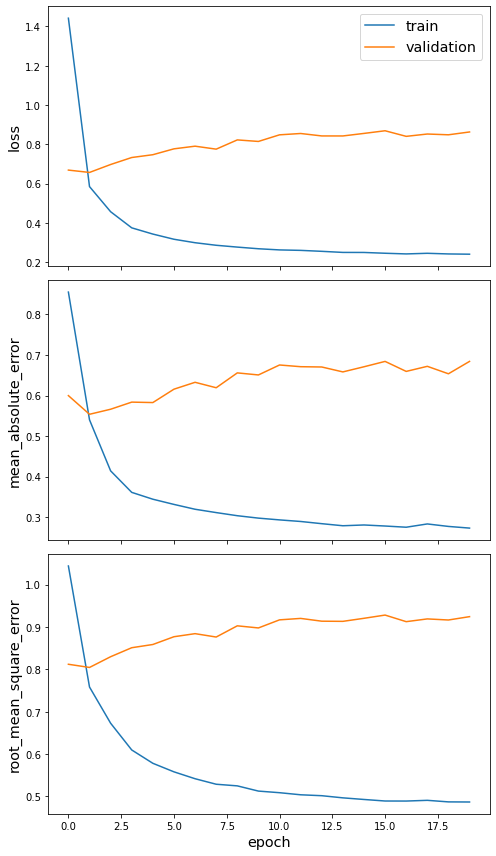

In [19]:
sg.utils.plot_history(history)

In [20]:
## After Model Training Accuracy

test_metrics = graphicoranko_without_metadata.model.evaluate(
    graphicoranko_without_metadata.test_gen, verbose=1, use_multiprocessing=False, workers=4
)

print("Trained model's Test Evaluation:")
for name, val in zip(graphicoranko_without_metadata.model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

50/50 [==============================] - 16s 309ms/step - loss: 0.8640 - root_mean_square_error: 0.9254 - mean_absolute_error: 0.6840
Trained model's Test Evaluation:
	loss: 0.8640
	root_mean_square_error: 0.9254
	mean_absolute_error: 0.6840


## Model Validation

In [21]:
graphicoranko_without_metadata.validate_model_accuracy()

50/50 [==============================] - 16s 301ms/step - loss: 0.8611 - root_mean_square_error: 0.9237 - mean_absolute_error: 0.6834
Test Evaluation:
	loss: 0.8611
	root_mean_square_error: 0.9237
	mean_absolute_error: 0.6834
Mean Baseline Test set metrics:
	root_mean_square_error =  0.8387633071886186
	mean_absolute_error =  0.6390086396245367

Model Test set metrics:
	root_mean_square_error =  0.9286191388633156
	mean_absolute_error =  0.6842190629443137


In [22]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = graphicoranko_without_metadata.model.predict(graphicoranko_without_metadata.test_gen)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, 3)

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  1.759674373487669
	mean_absolute_error =  1.6490374873353597

Model Test set metrics:
	root_mean_square_error =  0.9296596925553711
	mean_absolute_error =  0.6839647777295523


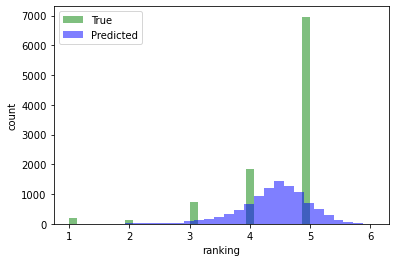

In [23]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()

In [24]:
np.mean(y_true[y_true == 5.0])

5.0

# Running HinSage Model with "category" as metadata 

## Graph Generation for Graph Neural Network Models


In [25]:
graph_with_meta_encoding = dataset.create_graph_for_training(users, items, edge_ratings, metadata=True)


In [26]:
print("--------Numer of Node and edges in Graph -----------")
print("Number of nodes in networkx graph {}, number of eges {}".format(len(graph_with_meta_encoding.nodes()), len(graph_with_meta_encoding.edges())))

--------Numer of Node and edges in Graph -----------
Number of nodes in networkx graph 21742, number of eges 31931


In [27]:
print("---- User Node Features --------")
graph_with_meta_encoding.node_features(node_type = 'user').shape

---- User Node Features --------


(1000, 1000)

In [28]:
print("---- Item Node Features --------")
graph_with_meta_encoding.node_features(node_type = 'item').shape

---- Item Node Features --------


(20742, 1041)

## Compile GraphicoRango Model with Metadata

In [29]:
batch_size = 200
epochs = 20
num_samples = [8, 4]
graphicoranko_with_metadata = GraphicoRango(edgelist_train, edgelist_test, labels_train, labels_test, epochs, batch_size, graph_with_one_hoting_encoding, num_samples)

In [30]:
graphicoranko_with_metadata.compile()

{'item': [EdgeType(n1='item', rel='default', n2='user')], 'user': [EdgeType(n1='user', rel='default', n2='item')]}
link_regression: using 'concat' method to combine node embeddings into edge embeddings
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 8, 20742)]   0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 32, 1000)]   0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 32, 20742)]  0                                            
________________________________________________________________________________________

## Train Model

In [31]:
## Before training Model accuracy

test_metrics = graphicoranko_with_metadata.model.evaluate(
    graphicoranko_with_metadata.test_gen, verbose=1, use_multiprocessing=False, workers=4
)

print("Untrained model's Test Evaluation:")
for name, val in zip(graphicoranko_with_metadata.model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

50/50 [==============================] - 16s 302ms/step - loss: 21.6678 - root_mean_square_error: 4.6546 - mean_absolute_error: 4.5726
Untrained model's Test Evaluation:
	loss: 21.6746
	root_mean_square_error: 4.6560
	mean_absolute_error: 4.5757


In [32]:
history = graphicoranko_with_metadata.train_model()

Epoch 1/20
116/116 [==============================] - 113s 964ms/step - loss: 1.4266 - root_mean_square_error: 1.0353 - mean_absolute_error: 0.8503 - val_loss: 0.6654 - val_root_mean_square_error: 0.8097 - val_mean_absolute_error: 0.5919
Epoch 2/20
116/116 [==============================] - 114s 979ms/step - loss: 0.5906 - root_mean_square_error: 0.7635 - mean_absolute_error: 0.5408 - val_loss: 0.6575 - val_root_mean_square_error: 0.8054 - val_mean_absolute_error: 0.5725
Epoch 3/20
116/116 [==============================] - 119s 1s/step - loss: 0.4445 - root_mean_square_error: 0.6618 - mean_absolute_error: 0.4031 - val_loss: 0.7039 - val_root_mean_square_error: 0.8342 - val_mean_absolute_error: 0.5917
Epoch 4/20
116/116 [==============================] - 122s 1s/step - loss: 0.3593 - root_mean_square_error: 0.5952 - mean_absolute_error: 0.3478 - val_loss: 0.7819 - val_root_mean_square_error: 0.8800 - val_mean_absolute_error: 0.6302
Epoch 5/20
116/116 [==============================] - 

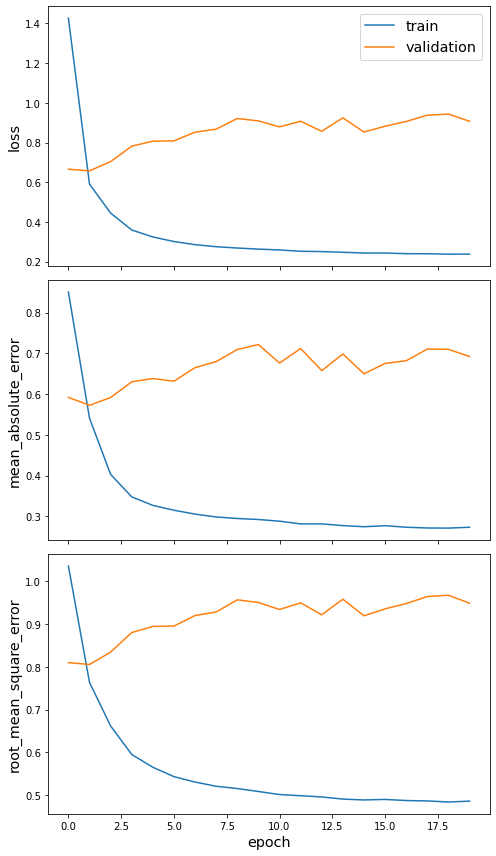

In [33]:
# Print History
sg.utils.plot_history(history)

In [34]:
## After Model Training Accuracy

test_metrics = graphicoranko_with_metadata.model.evaluate(
    graphicoranko_with_metadata.test_gen, verbose=1, use_multiprocessing=False, workers=4
)

print("Trained model's Test Evaluation:")
for name, val in zip(graphicoranko_with_metadata.model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

50/50 [==============================] - 25s 480ms/step - loss: 0.9049 - root_mean_square_error: 0.9473 - mean_absolute_error: 0.6920
Trained model's Test Evaluation:
	loss: 0.9049
	root_mean_square_error: 0.9473
	mean_absolute_error: 0.6920


## Model Validation

In [35]:
graphicoranko_with_metadata.validate_model_accuracy()

50/50 [==============================] - 23s 455ms/step - loss: 0.9029 - root_mean_square_error: 0.9463 - mean_absolute_error: 0.6908
Test Evaluation:
	loss: 0.9029
	root_mean_square_error: 0.9463
	mean_absolute_error: 0.6908
Mean Baseline Test set metrics:
	root_mean_square_error =  0.8387633071886186
	mean_absolute_error =  0.6390086396245367

Model Test set metrics:
	root_mean_square_error =  0.9514469607796283
	mean_absolute_error =  0.6920287059312412


In [39]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = graphicoranko_with_metadata.model.predict(graphicoranko_with_metadata.test_gen)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, 3)

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  1.759674373487669
	mean_absolute_error =  1.6490374873353597

Model Test set metrics:
	root_mean_square_error =  0.9513726871393382
	mean_absolute_error =  0.6925992087148727


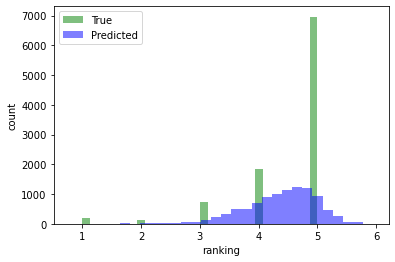

In [37]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()